

 # Semantic Detector Evaluation

## Empirical Analysis of Prototypical Learning with DistilBERT for MCP Security

---

### Abstract

This notebook presents a comprehensive evaluation of the Semantic Detector, the primary deep learning component of the MCP Security Gateway ensemble. The detector employs DistilBERT embeddings with prototypical learning for binary security classification, computing cosine distances to class prototypes for each tool.

### Detector Characteristics

| Property | Value |
|----------|-------|
| **Type** | Deep Learning (Prototypical Networks) |
| **Encoder** | DistilBERT (768-dim embeddings) |
| **Method** | Prototype-based classification |
| **Distance** | Cosine similarity |
| **Features** | Security-augmented embeddings (768 + 6) |

### Prototypical Learning Framework

Following Snell et al. (2017), the detector:
1. Computes class prototypes as mean embeddings of training samples
2. Classifies queries based on distance to nearest prototype
3. Uses margin-based decision boundary for fail-safe behavior

### Mathematical Formulation

$$p(y = k | x) = \frac{\exp(-d(f_\theta(x), c_k))}{\sum_{k'} \exp(-d(f_\theta(x), c_{k'}))}$$

Where:
- $f_\theta(x)$ is the embedding of input $x$
- $c_k$ is the prototype of class $k$
- $d(\cdot, \cdot)$ is cosine distance

### References

- Snell, J., Swersky, K., & Zemel, R. (2017). *Prototypical Networks for Few-shot Learning*. NeurIPS.
- Sanh, V., et al. (2019). *DistilBERT, a distilled version of BERT*. arXiv.

---

## 1. Environment Configuration

In [1]:
import os
import sys
import json
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple, Any, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configure project paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.insert(0, PROJECT_ROOT)

# Import detector
from mcp_bridge.src.core.detectors.semantic import SemanticDetector
from mcp_bridge.src.core.detectors.base import SecurityClass

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Semantic Detector Evaluation")
print(f"="*60)
print(f"Project Root: {PROJECT_ROOT}")
print(f"PyTorch Version: {torch.__version__}")

Semantic Detector Evaluation
Project Root: w:\__Projects__\MCP-Security-Gateway
PyTorch Version: 2.9.1+cu130


## 2. Visualization Configuration

In [2]:
# Color palette
COLORS = {
    'primary': '#F0E442',      # Yellow - Semantic detector
    'benign': '#009E73',       # Green - Safe
    'attack': '#D55E00',       # Vermillion - Threat
    'neutral': '#7F7F7F',      # Gray
    'secondary': '#0072B2',    # Blue
    'prototype': '#CC79A7',    # Pink - Prototypes
}

# Publication-quality matplotlib configuration
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Output directories
FIGURES_DIR = os.path.join(PROJECT_ROOT, 'research', 'figures', 'semantic')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'research', 'evaluation_results')
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Figures: {FIGURES_DIR}")
print(f"Results: {RESULTS_DIR}")

Figures: w:\__Projects__\MCP-Security-Gateway\research\figures\semantic
Results: w:\__Projects__\MCP-Security-Gateway\research\evaluation_results


## 3. Data Loading and Model Initialization

In [3]:
# Load datasets
TRAIN_DATA_PATH = os.path.join(PROJECT_ROOT, "research", "data", "training_dataset.json")
TEST_DATA_PATH = os.path.join(PROJECT_ROOT, "research", "data", "test_dataset.json")
MODELS_DIR = os.path.join(PROJECT_ROOT, "research", "trained_models")
SEMANTIC_MODEL_PATH = os.path.join(MODELS_DIR, "semantic_model.pt")

def load_dataset(path: str) -> Dict:
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    data.pop('_metadata', None)
    return data

def flatten_samples(dataset: Dict) -> List[Dict]:
    samples = []
    for tool_name, tool_data in dataset.items():
        for category in ['benign', 'attack']:
            for payload in tool_data.get(category, []):
                if isinstance(payload, dict):
                    payload_str = json.dumps(payload)
                else:
                    payload_str = str(payload)
                samples.append({
                    'tool_name': tool_name,
                    'payload': payload_str,
                    'label': category
                })
    return samples

train_dataset = load_dataset(TRAIN_DATA_PATH)
test_dataset = load_dataset(TEST_DATA_PATH)

train_samples = flatten_samples(train_dataset)
test_samples = flatten_samples(test_dataset)

print(f"Training samples: {len(train_samples)}")
print(f"Test samples: {len(test_samples)}")

Training samples: 3088
Test samples: 304


In [4]:
# Initialize and load semantic detector
semantic_detector = SemanticDetector(model_name="distilbert-base-uncased", sigma=3.0)

if os.path.exists(SEMANTIC_MODEL_PATH):
    state = torch.load(SEMANTIC_MODEL_PATH, map_location='cpu', weights_only=False)
    semantic_detector.load_state(state)
    metadata = state.get('metadata', {})
    print(f"Semantic model loaded from: {SEMANTIC_MODEL_PATH}")
    print(f"  Version: {metadata.get('version', 'unknown')}")
    print(f"  Tools trained: {len(semantic_detector.prototypes)}")
    print(f"  Tools: {list(semantic_detector.prototypes.keys())}")
else:
    print("Pre-trained model not found. Training from scratch...")
    for tool_name, tool_data in train_dataset.items():
        benign = tool_data.get('benign', [])
        attack = tool_data.get('attack', [])
        semantic_detector.fit(tool_name, benign, attack)
    print(f"Training complete: {len(semantic_detector.prototypes)} tools")

Semantic model loaded from: w:\__Projects__\MCP-Security-Gateway\research\trained_models\semantic_model.pt
  Version: unknown
  Tools trained: 32
  Tools: ['check_file_exists', 'check_url', 'convert_time', 'create_entity', 'create_relation', 'delete_entity', 'describe_table', 'deserialize_data', 'execute_command', 'fetch_html', 'fetch_url', 'get_current_time', 'get_entity', 'get_file_info', 'get_relations', 'graphql_query', 'ldap_query', 'list_directory', 'list_entities', 'list_tables', 'parse_xml', 'read_file', 'read_query', 'redis_command', 'render_template', 'run_script', 's3_operation', 'search_entities', 'send_webhook', 'verify_jwt', 'write_file', 'write_query']


## 4. Model Architecture Analysis

### 4.1 Prototype Statistics

In [5]:
# Analyze prototype structure
print("Prototype Structure Analysis")
print("="*60)

prototype_info = []
for tool_name, tool_prototypes in semantic_detector.prototypes.items():
    tool_stats = semantic_detector.class_stats.get(tool_name, {})
    tool_thresholds = semantic_detector.thresholds.get(tool_name, {})
    
    for class_name, prototype in tool_prototypes.items():
        class_stats = tool_stats.get(class_name, {})
        prototype_info.append({
            'tool': tool_name,
            'class': class_name,
            'embedding_dim': prototype.shape[-1],
            'n_samples': class_stats.get('n_samples', 0),
            'mean_dist': class_stats.get('mean', 0),
            'std_dist': class_stats.get('std', 0),
            'max_dist': class_stats.get('max_dist', 0)
        })

proto_df = pd.DataFrame(prototype_info)
print(f"\nEmbedding dimension: {proto_df['embedding_dim'].iloc[0] if len(proto_df) > 0 else 'N/A'}")
print(f"Total prototypes: {len(proto_df)}")
print(f"\nPrototype Statistics:")
print(proto_df.to_string(index=False))

Prototype Structure Analysis

Embedding dimension: 774
Total prototypes: 64

Prototype Statistics:
             tool  class  embedding_dim  n_samples  mean_dist  std_dist  max_dist
check_file_exists benign            774         16   0.016226  0.006835  0.028946
check_file_exists attack            774         16   0.056613  0.048249  0.179338
        check_url benign            774         23   0.022438  0.026450  0.106415
        check_url attack            774         23   0.028794  0.012060  0.068073
     convert_time benign            774         21   0.015236  0.016097  0.050365
     convert_time attack            774         21   0.039641  0.015940  0.069086
    create_entity benign            774         21   0.017143  0.005845  0.033571
    create_entity attack            774         21   0.023384  0.007756  0.042267
  create_relation benign            774          9   0.008999  0.002761  0.014064
  create_relation attack            774          9   0.012283  0.007165  0.028878

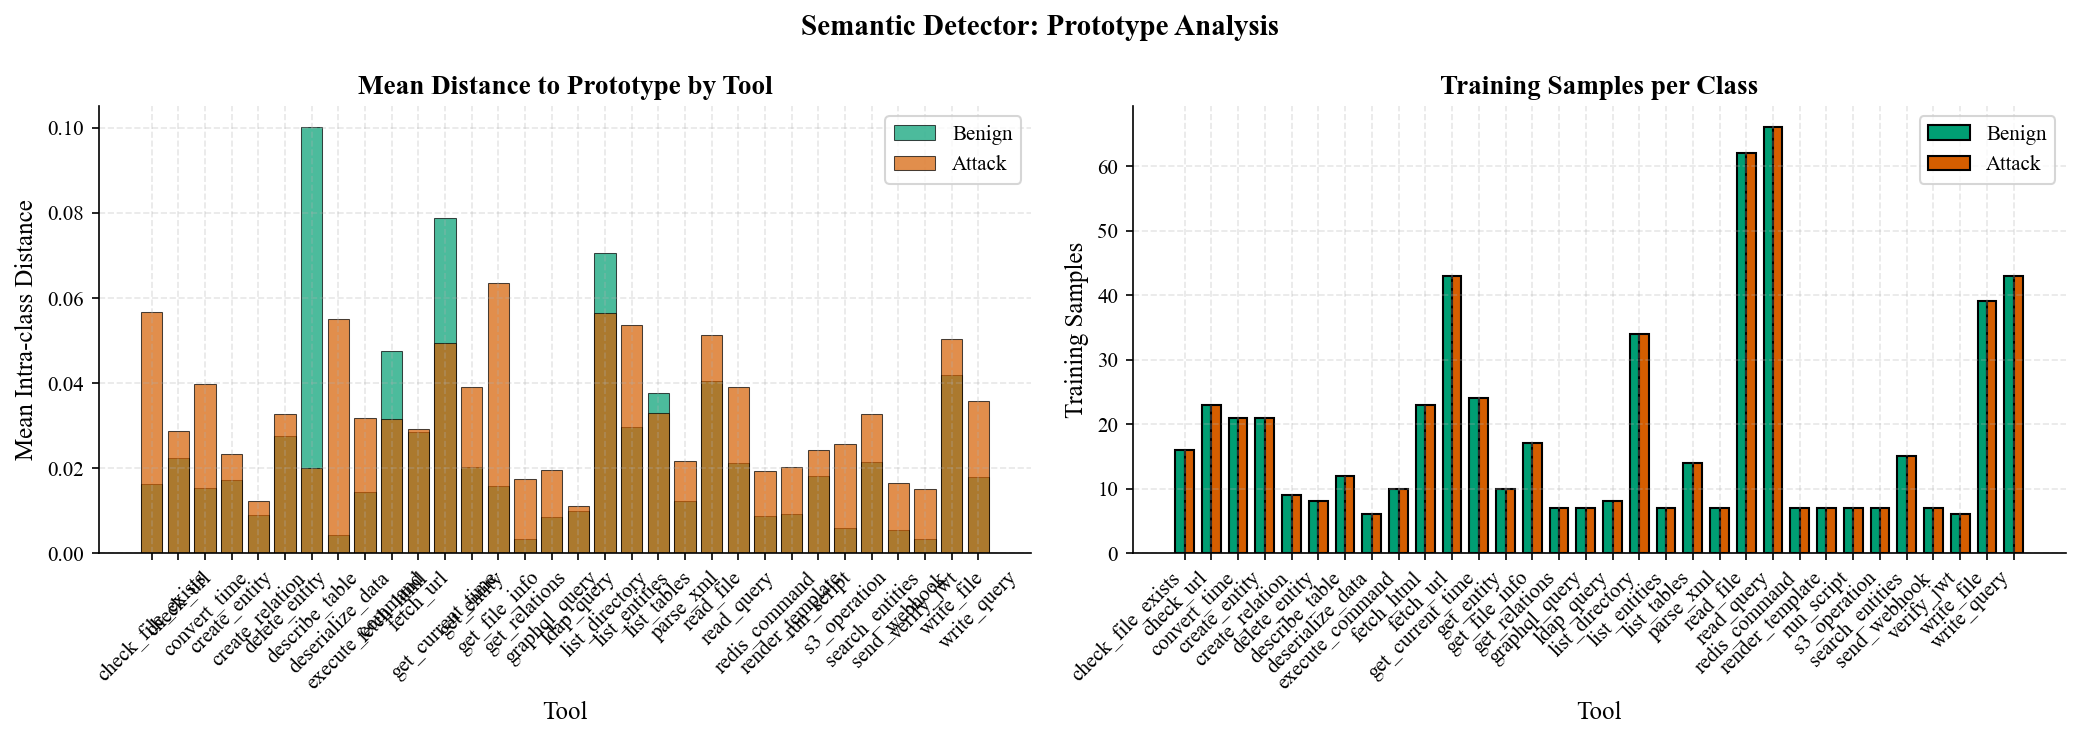

In [6]:
# Visualize intra-class distance statistics
if len(proto_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean distances by class
    ax1 = axes[0]
    for class_name, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
        class_df = proto_df[proto_df['class'] == class_name]
        ax1.bar(class_df['tool'], class_df['mean_dist'], color=color, alpha=0.7,
               label=class_name.capitalize(), edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Tool')
    ax1.set_ylabel('Mean Intra-class Distance')
    ax1.set_title('Mean Distance to Prototype by Tool')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Sample counts by class
    ax2 = axes[1]
    tools = proto_df['tool'].unique()
    x = np.arange(len(tools))
    width = 0.35
    
    benign_counts = [proto_df[(proto_df['tool'] == t) & (proto_df['class'] == 'benign')]['n_samples'].values[0]
                    if len(proto_df[(proto_df['tool'] == t) & (proto_df['class'] == 'benign')]) > 0 else 0
                    for t in tools]
    attack_counts = [proto_df[(proto_df['tool'] == t) & (proto_df['class'] == 'attack')]['n_samples'].values[0]
                    if len(proto_df[(proto_df['tool'] == t) & (proto_df['class'] == 'attack')]) > 0 else 0
                    for t in tools]
    
    ax2.bar(x - width/2, benign_counts, width, label='Benign', color=COLORS['benign'], edgecolor='black')
    ax2.bar(x + width/2, attack_counts, width, label='Attack', color=COLORS['attack'], edgecolor='black')
    ax2.set_xlabel('Tool')
    ax2.set_ylabel('Training Samples')
    ax2.set_title('Training Samples per Class')
    ax2.set_xticks(x)
    ax2.set_xticklabels(tools, rotation=45, ha='right')
    ax2.legend()
    
    plt.suptitle('Semantic Detector: Prototype Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'prototype_analysis.png'), dpi=600)
    plt.show()

### 4.2 Inter-Prototype Distances

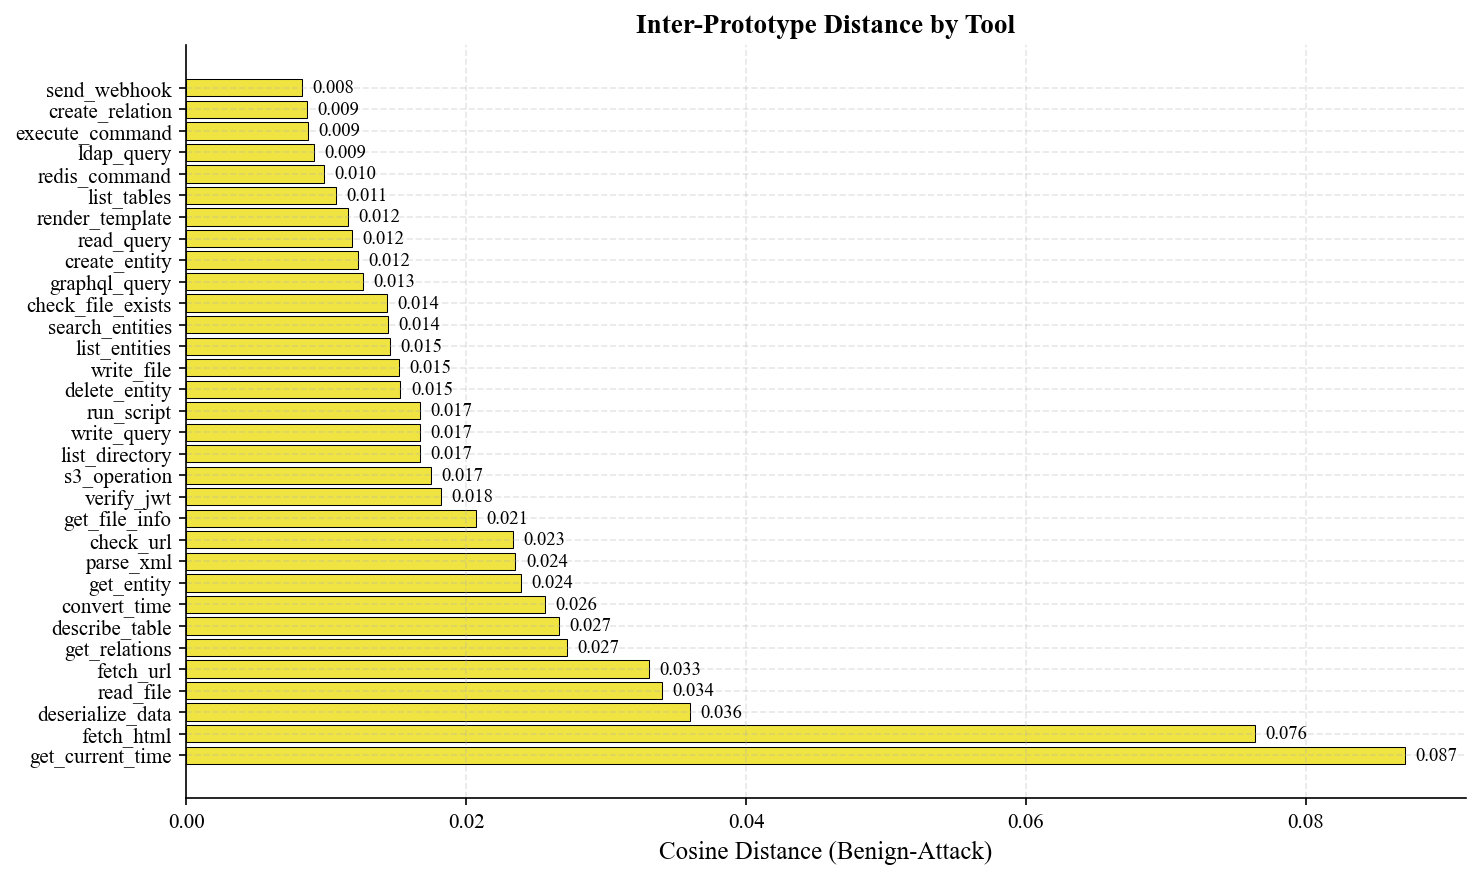


Inter-Prototype Distances (Benign vs Attack):
             tool  cosine_similarity  cosine_distance
 get_current_time           0.912946         0.087054
       fetch_html           0.923634         0.076366
 deserialize_data           0.964043         0.035957
        read_file           0.965999         0.034001
        fetch_url           0.966939         0.033061
    get_relations           0.972774         0.027226
   describe_table           0.973380         0.026620
     convert_time           0.974363         0.025637
       get_entity           0.976096         0.023904
        parse_xml           0.976488         0.023512
        check_url           0.976684         0.023316
    get_file_info           0.979317         0.020683
       verify_jwt           0.981845         0.018155
     s3_operation           0.982558         0.017442
   list_directory           0.983284         0.016716
      write_query           0.983290         0.016710
       run_script           0.98329

In [7]:
# Compute inter-prototype distances
inter_distances = []
for tool_name, tool_prototypes in semantic_detector.prototypes.items():
    if 'benign' in tool_prototypes and 'attack' in tool_prototypes:
        p_benign = tool_prototypes['benign']
        p_attack = tool_prototypes['attack']
        
        cosine_sim = F.cosine_similarity(p_benign, p_attack).item()
        cosine_dist = 1.0 - cosine_sim
        
        inter_distances.append({
            'tool': tool_name,
            'cosine_similarity': cosine_sim,
            'cosine_distance': cosine_dist
        })

if inter_distances:
    inter_df = pd.DataFrame(inter_distances).sort_values('cosine_distance', ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.barh(range(len(inter_df)), inter_df['cosine_distance'],
                   color=COLORS['primary'], edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(inter_df)))
    ax.set_yticklabels(inter_df['tool'])
    ax.set_xlabel('Cosine Distance (Benign-Attack)')
    ax.set_title('Inter-Prototype Distance by Tool')
    
    for bar, val in zip(bars, inter_df['cosine_distance']):
        ax.annotate(f'{val:.3f}', xy=(val, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0), textcoords='offset points', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'inter_prototype_distance.png'), dpi=600)
    plt.show()
    
    print("\nInter-Prototype Distances (Benign vs Attack):")
    print(inter_df.to_string(index=False))

## 5. Embedding Space Visualization

### 5.1 t-SNE Projection

In [8]:
# Extract embeddings for visualization
def extract_embeddings(samples: List[Dict], max_samples: int = 500) -> Tuple[np.ndarray, List[str], List[str]]:
    """Extract embeddings for visualization."""
    if len(samples) > max_samples:
        indices = np.random.choice(len(samples), max_samples, replace=False)
        samples = [samples[i] for i in indices]
    
    embeddings = []
    labels = []
    tools = []
    
    for sample in samples:
        emb = semantic_detector._get_embedding(sample['payload'])
        embeddings.append(emb.cpu().numpy().flatten())
        labels.append(sample['label'])
        tools.append(sample['tool_name'])
    
    return np.array(embeddings), labels, tools

print("Extracting embeddings for visualization...")
embeddings, labels, tools = extract_embeddings(test_samples, max_samples=500)
print(f"Extracted {len(embeddings)} embeddings (dim={embeddings.shape[1]})")

Extracting embeddings for visualization...
Extracted 304 embeddings (dim=774)


Computing t-SNE projection...


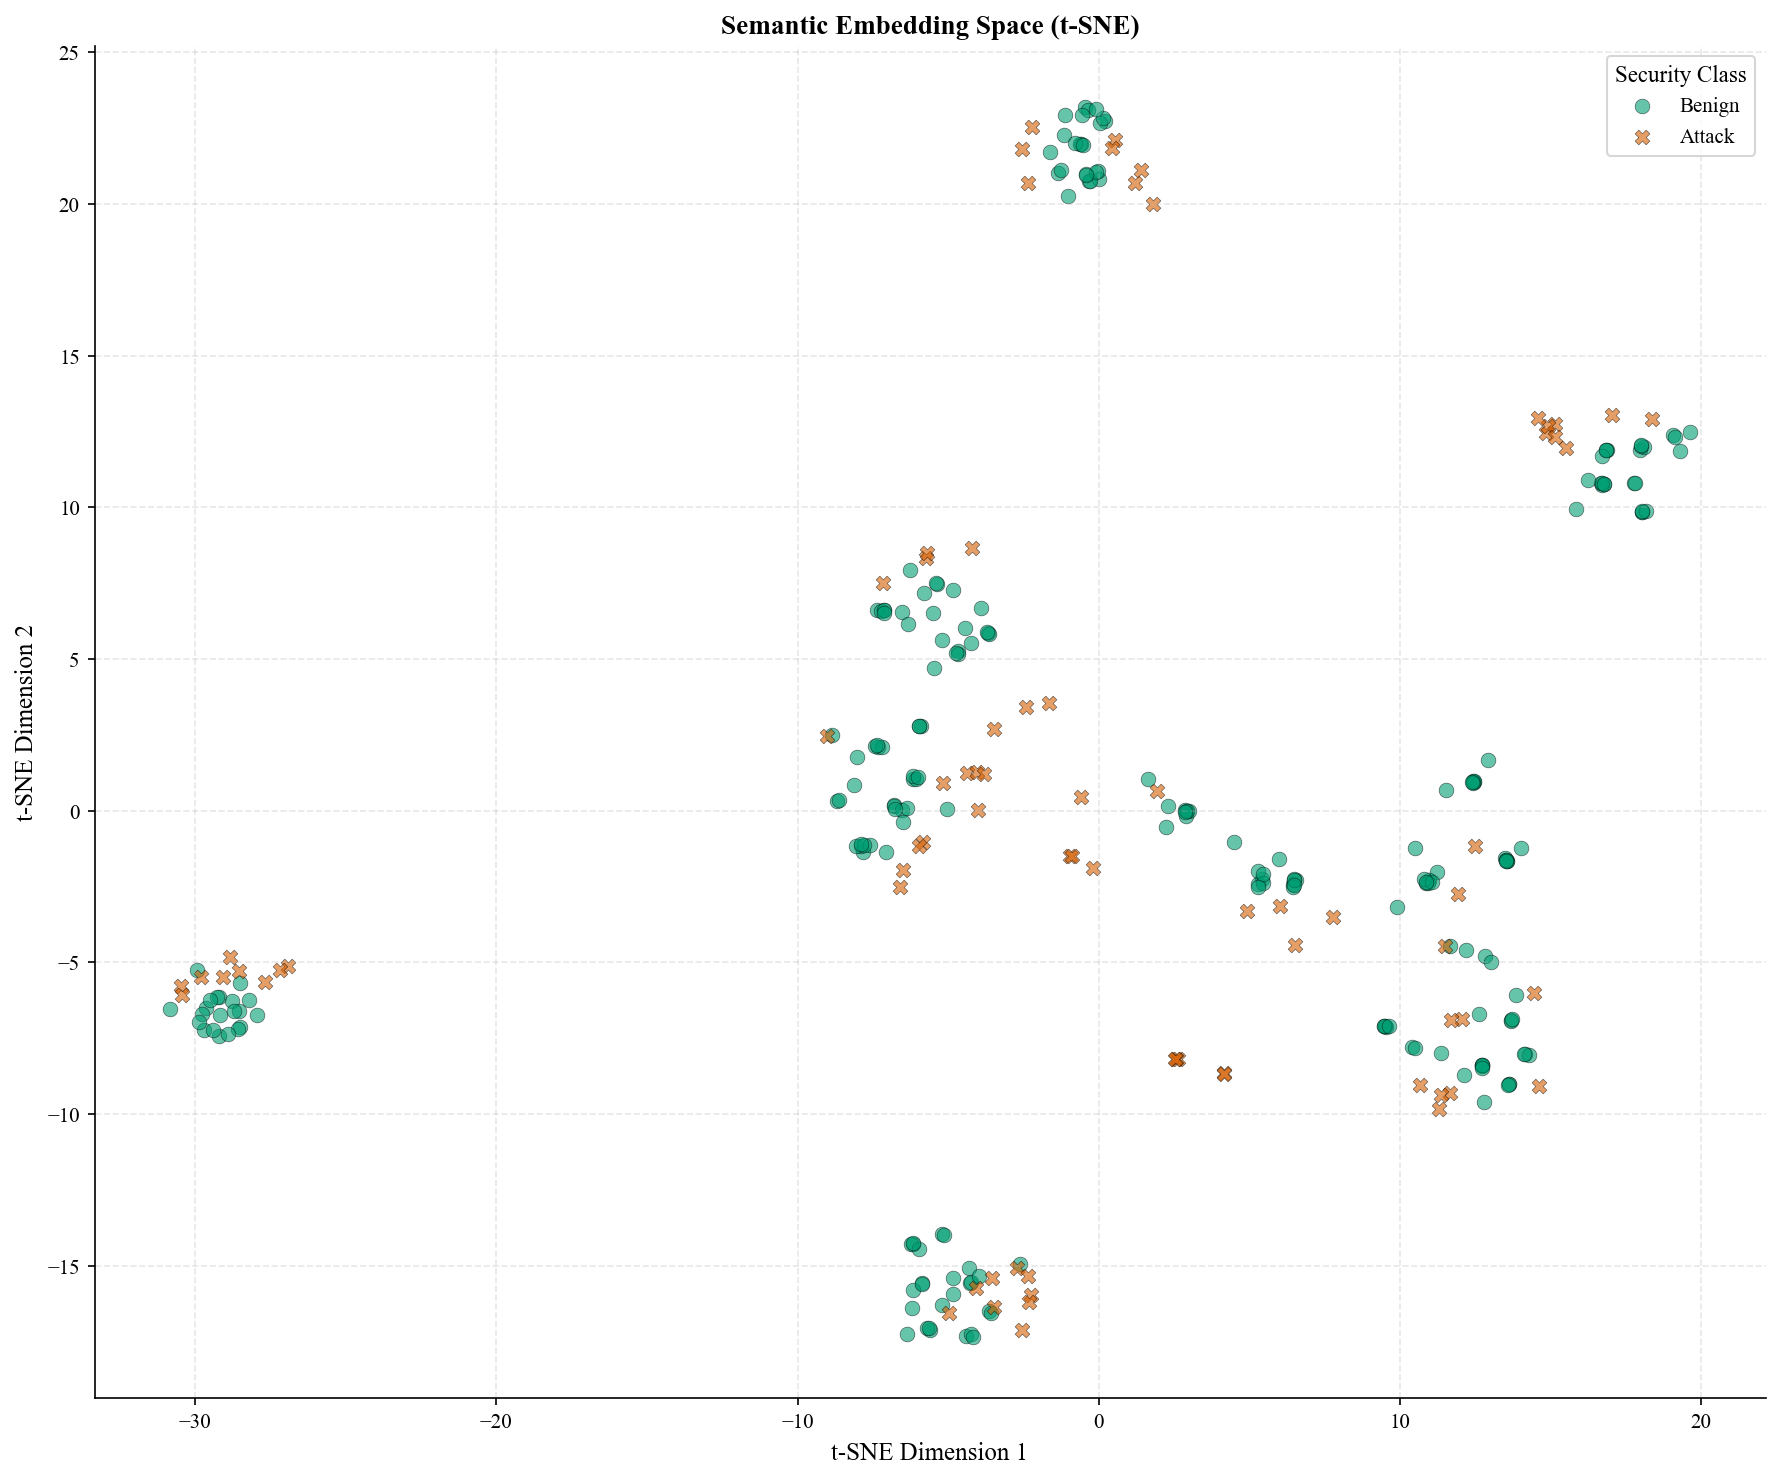

In [9]:
# t-SNE visualization
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_SEED, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(12, 10))

for label, color, marker in [('benign', COLORS['benign'], 'o'), ('attack', COLORS['attack'], 'X')]:
    mask = np.array(labels) == label
    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
              c=color, label=label.capitalize(), alpha=0.6, s=50,
              marker=marker, edgecolors='black', linewidth=0.3)

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('Semantic Embedding Space (t-SNE)')
ax.legend(title='Security Class')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'tsne_embeddings.png'), dpi=600)
plt.show()

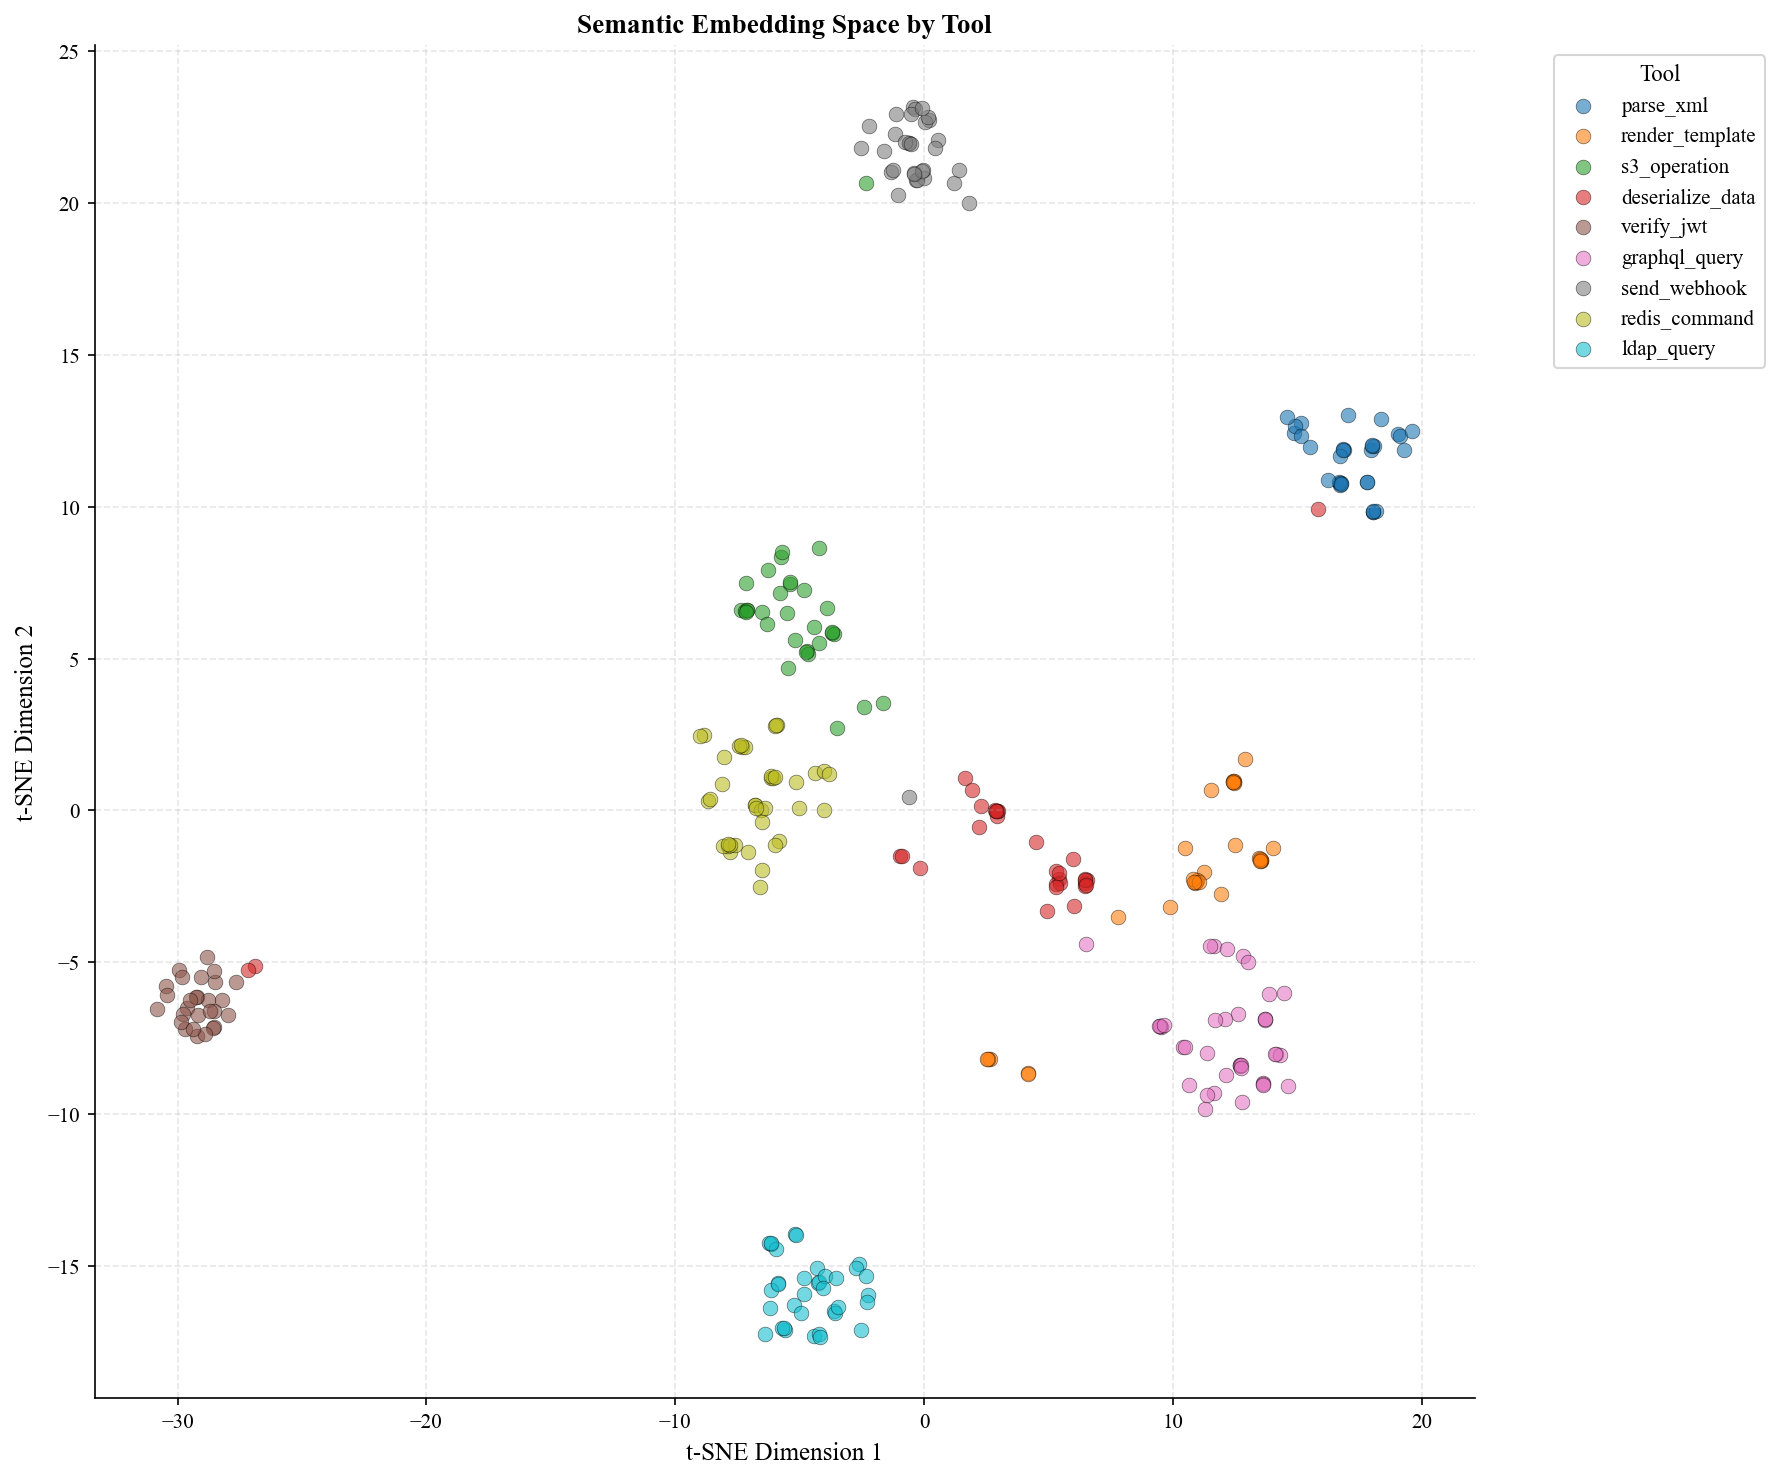

In [10]:
# t-SNE colored by tool
unique_tools = list(set(tools))
tool_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_tools)))
tool_color_map = {t: c for t, c in zip(unique_tools, tool_colors)}

fig, ax = plt.subplots(figsize=(12, 10))

for tool in unique_tools:
    mask = np.array(tools) == tool
    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
              c=[tool_color_map[tool]], label=tool, alpha=0.6, s=50,
              edgecolors='black', linewidth=0.3)

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('Semantic Embedding Space by Tool')
ax.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'tsne_by_tool.png'), dpi=600)
plt.show()

## 6. Model Evaluation

### 6.1 Predictions on Test Set

In [11]:
def evaluate_semantic_detector(samples: List[Dict]) -> pd.DataFrame:
    """Evaluate semantic detector on samples."""
    results = []
    
    for sample in samples:
        result = semantic_detector.predict(sample['payload'], sample['tool_name'])
        
        if result is None:
            pred_label = 'abstain'
            confidence = 0.0
            distances = {}
        else:
            pred_label = result.classification
            confidence = result.confidence
            distances = result.metadata.get('distances', {})
        
        results.append({
            'tool_name': sample['tool_name'],
            'payload': sample['payload'][:80],
            'true_label': sample['label'],
            'pred_label': pred_label,
            'confidence': confidence,
            'dist_benign': distances.get('benign', np.nan),
            'dist_attack': distances.get('attack', np.nan)
        })
    
    return pd.DataFrame(results)

print("Evaluating Semantic Detector on test set...")
eval_df = evaluate_semantic_detector(test_samples)
print(f"Evaluation complete: {len(eval_df)} samples")
print(f"\nPrediction distribution:")
print(eval_df['pred_label'].value_counts())

Evaluating Semantic Detector on test set...
Evaluation complete: 304 samples

Prediction distribution:
pred_label
benign    167
attack    137
Name: count, dtype: int64


### 6.2 Confusion Matrix

Coverage: 100.0% (304/304 samples)


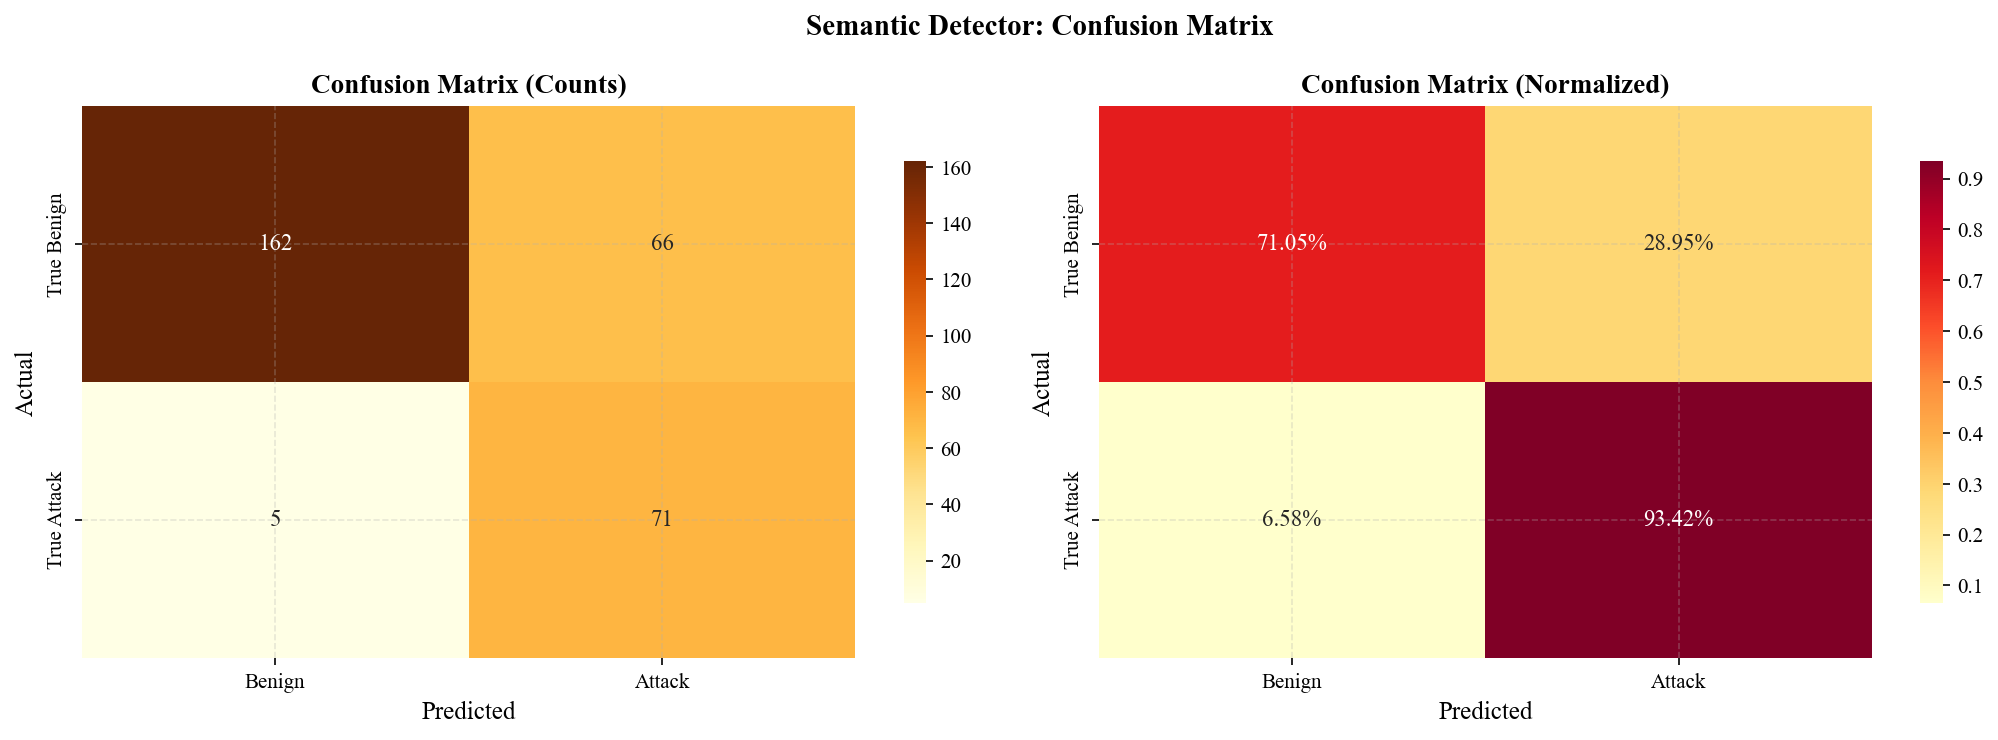

In [12]:
# Filter out abstentions
valid_df = eval_df[eval_df['pred_label'] != 'abstain'].copy()
coverage = len(valid_df) / len(eval_df)

print(f"Coverage: {coverage:.1%} ({len(valid_df)}/{len(eval_df)} samples)")

if len(valid_df) > 0:
    labels = ['benign', 'attack']
    cm = confusion_matrix(valid_df['true_label'], valid_df['pred_label'], labels=labels)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Absolute counts
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['True Benign', 'True Attack'],
                ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix (Counts)')
    
    # Normalized
    ax2 = axes[1]
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['True Benign', 'True Attack'],
                ax=ax2, cbar_kws={'shrink': 0.8})
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title('Confusion Matrix (Normalized)')
    
    plt.suptitle('Semantic Detector: Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'), dpi=600)
    plt.show()

### 6.3 Classification Metrics

In [13]:
if len(valid_df) > 0:
    y_true = (valid_df['true_label'] == 'attack').astype(int)
    y_pred = (valid_df['pred_label'] == 'attack').astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision_val = precision_score(y_true, y_pred, zero_division=0)
    recall_val = recall_score(y_true, y_pred, zero_division=0)
    f1_val = f1_score(y_true, y_pred, zero_division=0)
    
    print("Classification Metrics (Binary: Attack Detection)")
    print("="*60)
    print(f"Coverage: {coverage:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Attack']))

Classification Metrics (Binary: Attack Detection)
Coverage: 1.0000
Accuracy: 0.7664
Precision: 0.5182
Recall: 0.9342
F1-Score: 0.6667

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.71      0.82       228
      Attack       0.52      0.93      0.67        76

    accuracy                           0.77       304
   macro avg       0.74      0.82      0.74       304
weighted avg       0.86      0.77      0.78       304



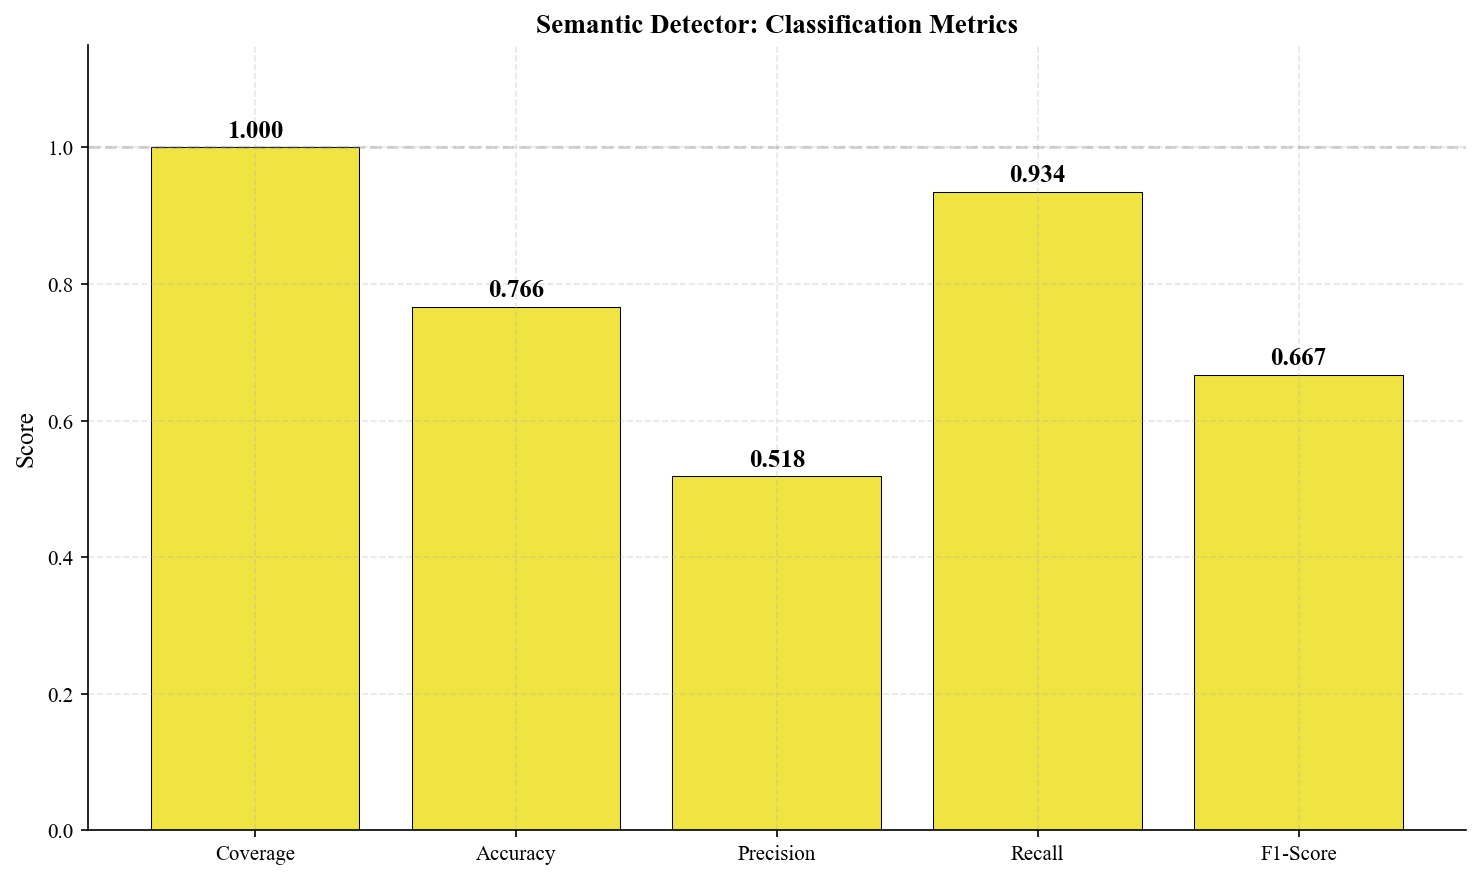

In [14]:
# Visualize metrics
if len(valid_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    metrics = ['Coverage', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [coverage, accuracy, precision_val, recall_val, f1_val]
    
    bars = ax.bar(metrics, values, color=COLORS['primary'], edgecolor='black', linewidth=0.5)
    
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center',
                    fontsize=12, fontweight='bold')
    
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Score')
    ax.set_title('Semantic Detector: Classification Metrics')
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'classification_metrics.png'), dpi=600)
    plt.show()

### 6.4 ROC Curve and AUC

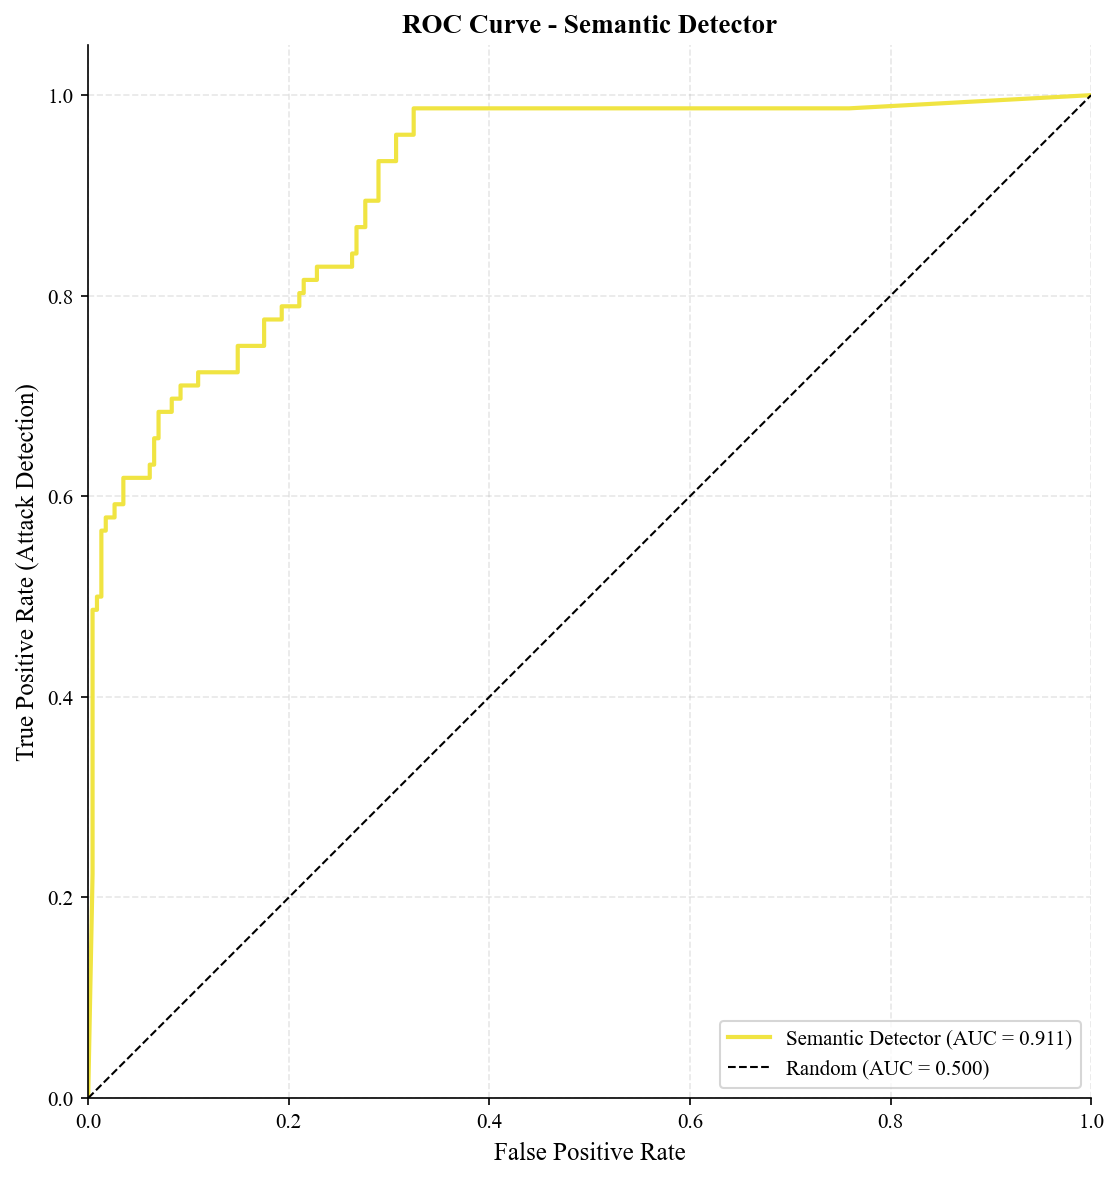

ROC-AUC Score: 0.9107


In [15]:
if len(valid_df) > 0:
    # Use confidence as score
    y_score = valid_df.apply(
        lambda r: r['confidence'] if r['pred_label'] == 'attack' else (1 - r['confidence']),
        axis=1
    )
    
    fpr_roc, tpr_roc, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr_roc, tpr_roc)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(fpr_roc, tpr_roc, color=COLORS['primary'], lw=2,
            label=f'Semantic Detector (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Attack Detection)')
    ax.set_title('ROC Curve - Semantic Detector')
    ax.legend(loc='lower right')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'), dpi=600)
    plt.show()
    
    print(f"ROC-AUC Score: {roc_auc:.4f}")

### 6.5 Precision-Recall Curve

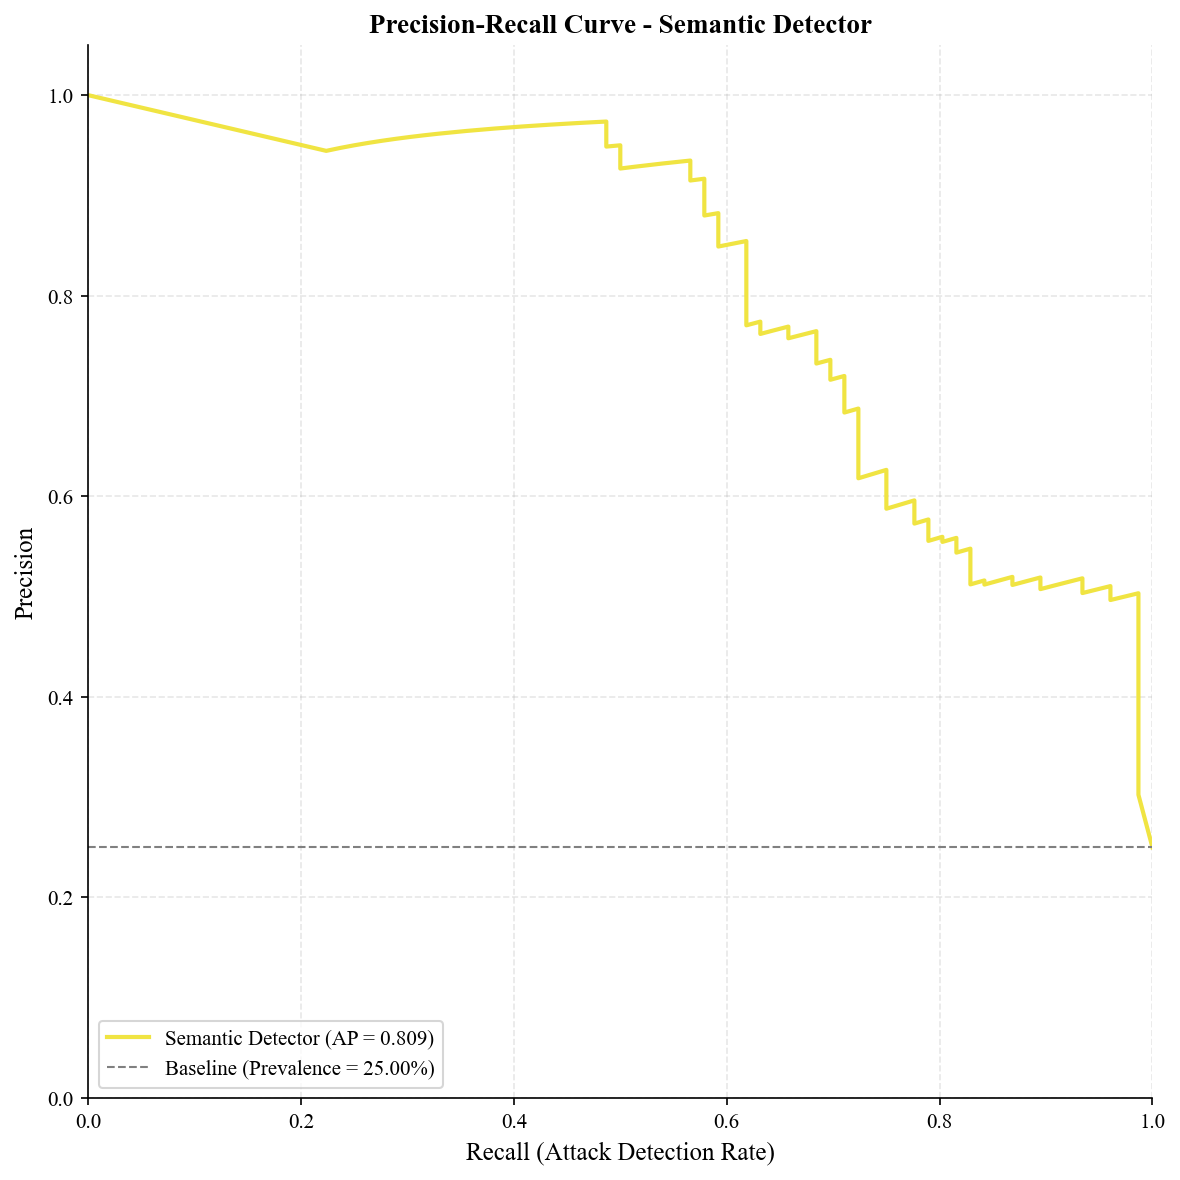

Average Precision (AP): 0.8092


In [16]:
if len(valid_df) > 0:
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(recall_curve, precision_curve, color=COLORS['primary'], lw=2,
            label=f'Semantic Detector (AP = {ap_score:.3f})')
    
    baseline = y_true.mean()
    ax.axhline(y=baseline, color='gray', linestyle='--', lw=1,
               label=f'Baseline (Prevalence = {baseline:.2%})')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('Recall (Attack Detection Rate)')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve - Semantic Detector')
    ax.legend(loc='lower left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'precision_recall_curve.png'), dpi=600)
    plt.show()
    
    print(f"Average Precision (AP): {ap_score:.4f}")

## 7. Prototype Distance Analysis

### 7.1 Distance Distributions

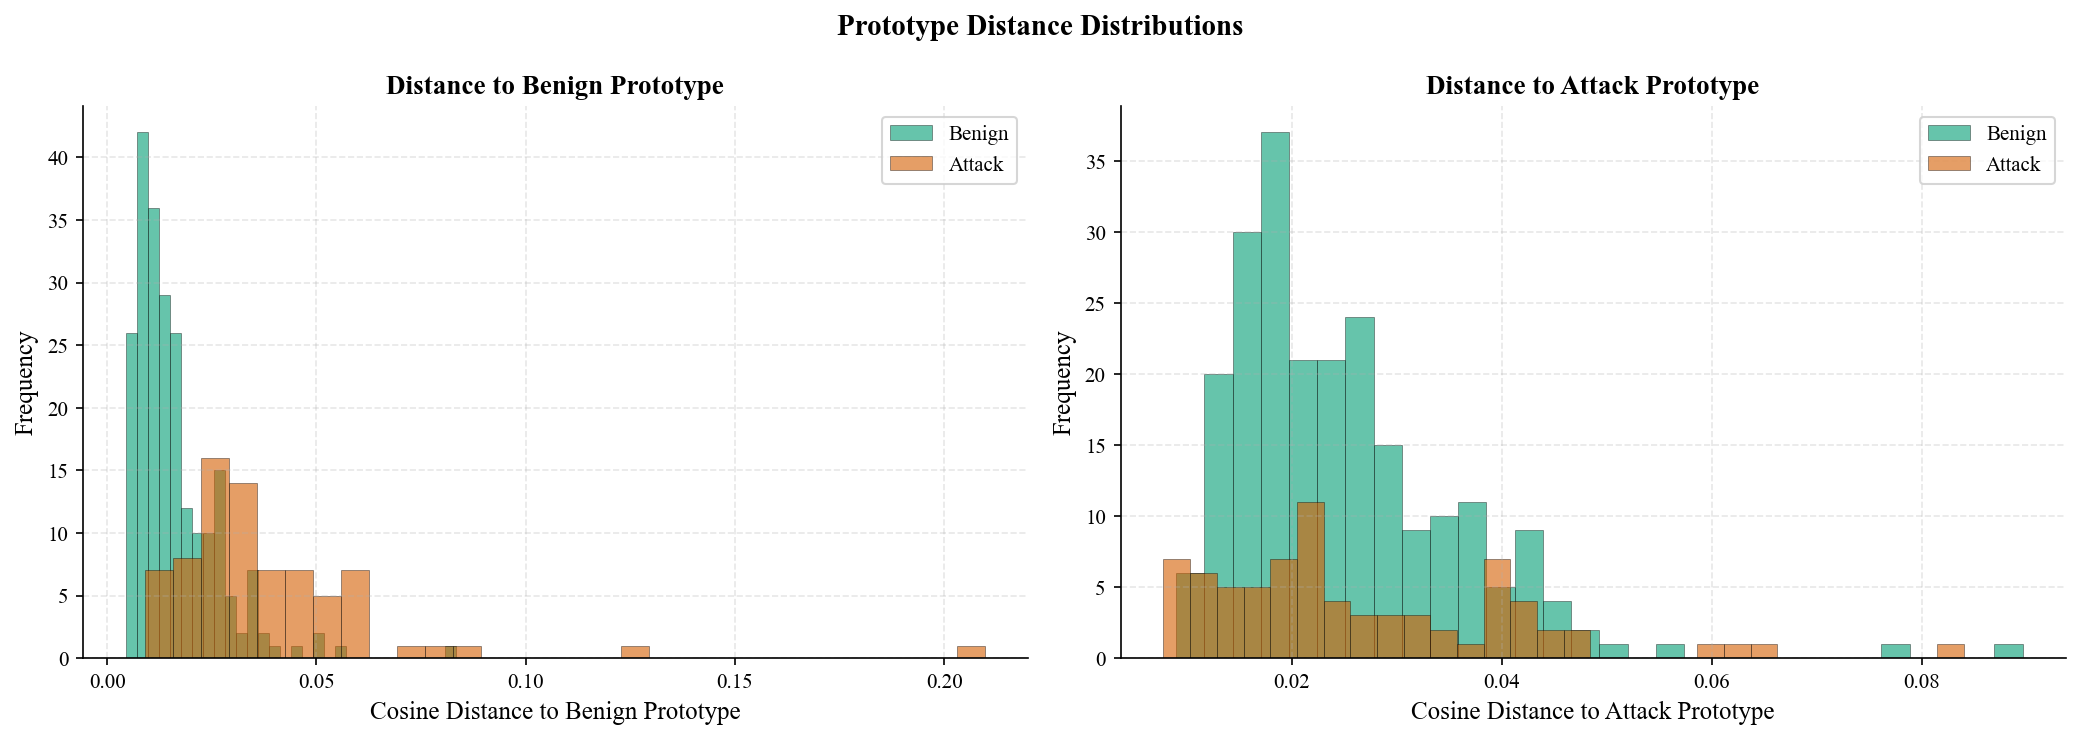

In [17]:
# Analyze distances to prototypes
dist_df = eval_df.dropna(subset=['dist_benign'])

if len(dist_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distance to benign prototype
    ax1 = axes[0]
    for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
        data = dist_df[dist_df['true_label'] == label]['dist_benign']
        ax1.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
                color=color, edgecolor='black', linewidth=0.3)
    ax1.set_xlabel('Cosine Distance to Benign Prototype')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distance to Benign Prototype')
    ax1.legend()
    
    # Distance to attack prototype
    ax2 = axes[1]
    dist_attack_df = dist_df.dropna(subset=['dist_attack'])
    if len(dist_attack_df) > 0:
        for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
            data = dist_attack_df[dist_attack_df['true_label'] == label]['dist_attack']
            ax2.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
                    color=color, edgecolor='black', linewidth=0.3)
        ax2.set_xlabel('Cosine Distance to Attack Prototype')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distance to Attack Prototype')
        ax2.legend()
    
    plt.suptitle('Prototype Distance Distributions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'prototype_distances.png'), dpi=600)
    plt.show()

### 7.2 Decision Margin Analysis

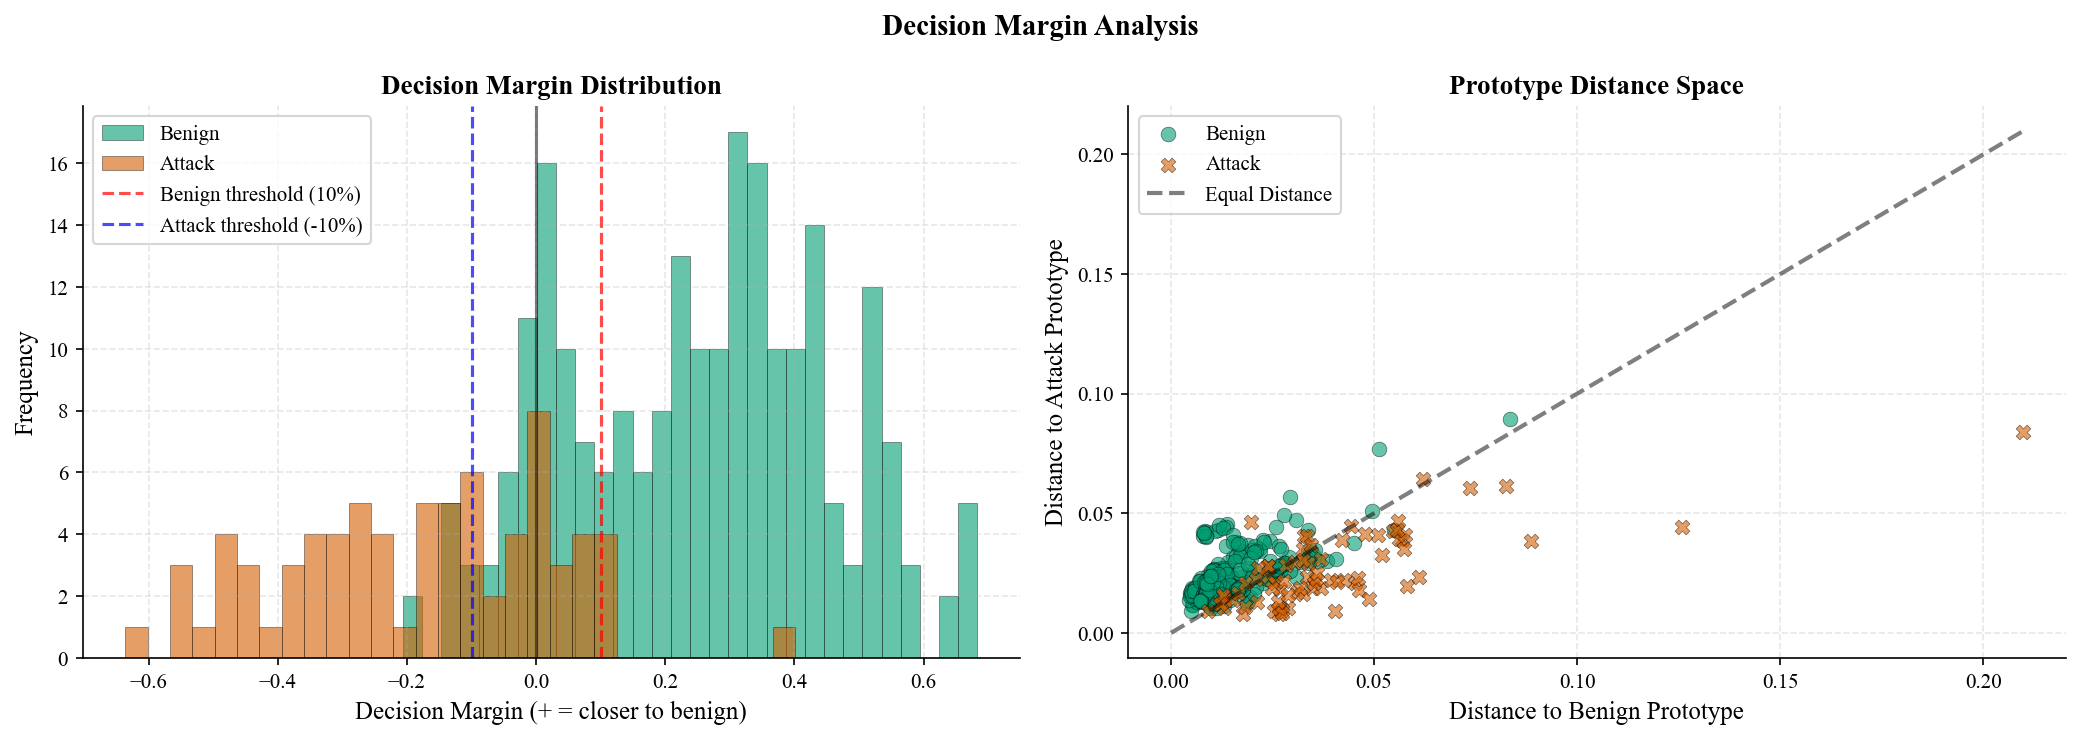

In [18]:
# Analyze decision margins
both_dist_df = eval_df.dropna(subset=['dist_benign', 'dist_attack']).copy()

if len(both_dist_df) > 0:
    # Compute margin
    both_dist_df['margin'] = (both_dist_df['dist_attack'] - both_dist_df['dist_benign']) / \
                             (both_dist_df['dist_attack'] + both_dist_df['dist_benign'] + 1e-9)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Margin distribution by class
    ax1 = axes[0]
    for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
        data = both_dist_df[both_dist_df['true_label'] == label]['margin']
        ax1.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
                color=color, edgecolor='black', linewidth=0.3)
    ax1.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Benign threshold (10%)')
    ax1.axvline(x=-0.1, color='blue', linestyle='--', alpha=0.7, label='Attack threshold (-10%)')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    ax1.set_xlabel('Decision Margin (+ = closer to benign)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Decision Margin Distribution')
    ax1.legend()
    
    # Scatter plot
    ax2 = axes[1]
    for label, color, marker in [('benign', COLORS['benign'], 'o'), ('attack', COLORS['attack'], 'X')]:
        mask = both_dist_df['true_label'] == label
        ax2.scatter(both_dist_df[mask]['dist_benign'],
                   both_dist_df[mask]['dist_attack'],
                   c=color, label=label.capitalize(), alpha=0.6, s=50,
                   marker=marker, edgecolors='black', linewidth=0.3)
    
    max_dist = max(both_dist_df['dist_benign'].max(), both_dist_df['dist_attack'].max())
    ax2.plot([0, max_dist], [0, max_dist], 'k--', lw=2, alpha=0.5, label='Equal Distance')
    ax2.set_xlabel('Distance to Benign Prototype')
    ax2.set_ylabel('Distance to Attack Prototype')
    ax2.set_title('Prototype Distance Space')
    ax2.legend()
    
    plt.suptitle('Decision Margin Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'decision_margin.png'), dpi=600)
    plt.show()

## 8. Per-Tool Analysis

In [19]:
# Per-tool performance
tool_metrics = []

for tool_name in eval_df['tool_name'].unique():
    tool_df = eval_df[eval_df['tool_name'] == tool_name]
    tool_valid = tool_df[tool_df['pred_label'] != 'abstain']
    
    if len(tool_valid) == 0:
        continue
    
    y_true_tool = (tool_valid['true_label'] == 'attack').astype(int)
    y_pred_tool = (tool_valid['pred_label'] == 'attack').astype(int)
    
    tool_metrics.append({
        'tool': tool_name,
        'samples': len(tool_df),
        'coverage': len(tool_valid) / len(tool_df),
        'accuracy': accuracy_score(y_true_tool, y_pred_tool),
        'f1_score': f1_score(y_true_tool, y_pred_tool, zero_division=0)
    })

tool_metrics_df = pd.DataFrame(tool_metrics).sort_values('f1_score', ascending=False)

print("Per-Tool Performance:")
print(tool_metrics_df.to_string(index=False))

Per-Tool Performance:
            tool  samples  coverage  accuracy  f1_score
       parse_xml       32       1.0  0.968750  0.941176
    send_webhook       32       1.0  0.875000  0.800000
      verify_jwt       28       1.0  0.857143  0.777778
      ldap_query       36       1.0  0.833333  0.750000
   redis_command       40       1.0  0.825000  0.720000
deserialize_data       32       1.0  0.812500  0.700000
   graphql_query       40       1.0  0.700000  0.571429
    s3_operation       32       1.0  0.531250  0.516129
 render_template       32       1.0  0.500000  0.466667


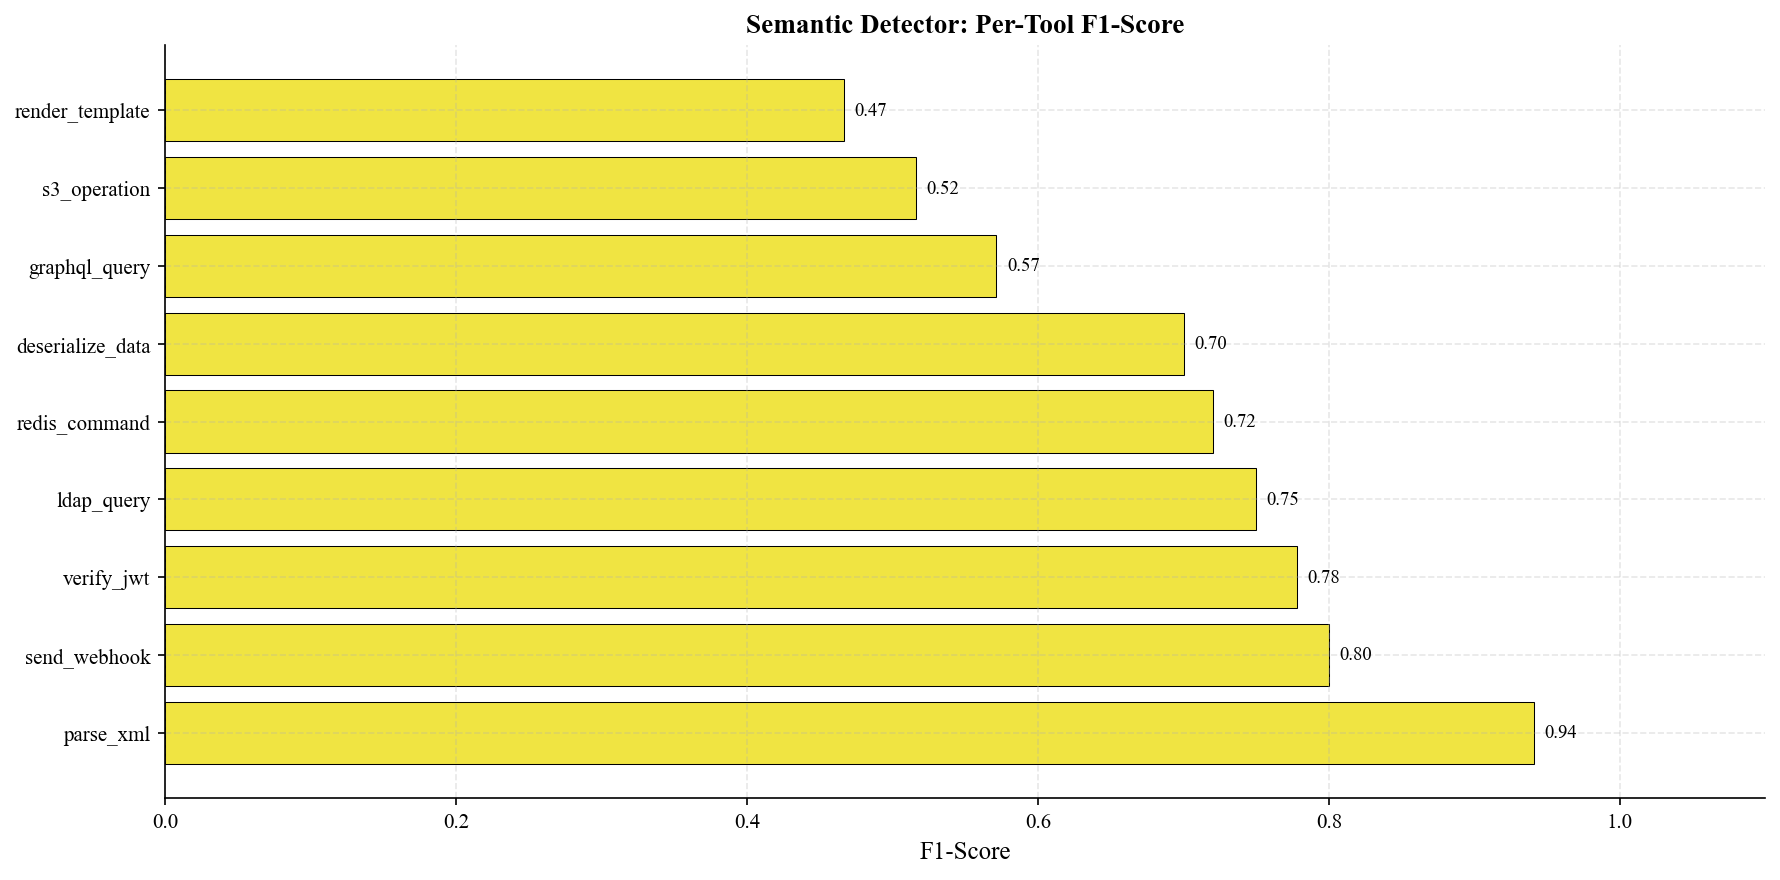

In [20]:
# Visualize per-tool F1 scores
if len(tool_metrics_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.barh(range(len(tool_metrics_df)), tool_metrics_df['f1_score'],
                   color=COLORS['primary'], edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(tool_metrics_df)))
    ax.set_yticklabels(tool_metrics_df['tool'])
    ax.set_xlabel('F1-Score')
    ax.set_title('Semantic Detector: Per-Tool F1-Score')
    ax.set_xlim(0, 1.1)
    
    for bar, val in zip(bars, tool_metrics_df['f1_score']):
        ax.annotate(f'{val:.2f}', xy=(val, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0), textcoords='offset points', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'per_tool_f1.png'), dpi=600)
    plt.show()

## 9. Summary and Export

In [22]:
# Compile summary
summary = {
    'detector': 'semantic',
    'classification_type': 'binary',
    'method': 'prototypical_learning',
    'encoder': 'distilbert-base-uncased',
    'embedding_dim': proto_df['embedding_dim'].iloc[0] if len(proto_df) > 0 else None,
    'tools_trained': list(semantic_detector.prototypes.keys()),
    'test_samples': len(eval_df),
    'metrics': {
        'coverage': float(coverage),
        'accuracy': float(accuracy) if len(valid_df) > 0 else None,
        'precision': float(precision_val) if len(valid_df) > 0 else None,
        'recall': float(recall_val) if len(valid_df) > 0 else None,
        'f1_score': float(f1_val) if len(valid_df) > 0 else None,
        'roc_auc': float(roc_auc) if len(valid_df) > 0 else None,
        'average_precision': float(ap_score) if len(valid_df) > 0 else None
    },
    'prototype_info': prototype_info,
    'inter_prototype_distances': inter_distances if inter_distances else [],
    'per_tool_metrics': tool_metrics
}

# Export
eval_df.to_csv(os.path.join(RESULTS_DIR, 'semantic_predictions.csv'), index=False)
proto_df.to_csv(os.path.join(RESULTS_DIR, 'semantic_prototypes.csv'), index=False)
tool_metrics_df.to_csv(os.path.join(RESULTS_DIR, 'semantic_per_tool.csv'), index=False)

with open(os.path.join(RESULTS_DIR, 'semantic_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print("Results exported successfully.")

Results exported successfully.


In [23]:
# Final summary
print("\n" + "="*70)
print("SEMANTIC DETECTOR EVALUATION SUMMARY")
print("="*70)
print(f"\nMethod: Prototypical Learning with DistilBERT")
print(f"Embedding dimension: {proto_df['embedding_dim'].iloc[0] if len(proto_df) > 0 else 'N/A'}")
print(f"Tools trained: {len(semantic_detector.prototypes)}")
print(f"\nBinary Classification Performance:")
if len(valid_df) > 0:
    print(f"  Coverage:  {coverage:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision_val:.4f}")
    print(f"  Recall:    {recall_val:.4f}")
    print(f"  F1-Score:  {f1_val:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  AP:        {ap_score:.4f}")
print("="*70)


SEMANTIC DETECTOR EVALUATION SUMMARY

Method: Prototypical Learning with DistilBERT
Embedding dimension: 774
Tools trained: 32

Binary Classification Performance:
  Coverage:  1.0000
  Accuracy:  0.7664
  Precision: 0.5182
  Recall:    0.9342
  F1-Score:  0.6667
  ROC-AUC:   0.9107
  AP:        0.8092


## Conclusions

### Key Findings

1. **Prototypical Learning**: The detector effectively learns class prototypes from training samples, enabling generalization to novel requests.

2. **Embedding Quality**: DistilBERT embeddings capture semantic meaning, allowing detection of semantically similar attacks.

3. **Margin-Based Classification**: The 10% margin threshold provides fail-safe behavior, defaulting to ATTACK for ambiguous cases.

4. **Per-Tool Adaptation**: Separate prototypes per tool enable tool-specific security policies.

### Role in Ensemble

The Semantic Detector:
- Provides the highest weight (0.35) in ensemble voting due to best generalization
- Captures semantic meaning beyond surface-level patterns
- Enables detection of novel attacks semantically similar to training examples
- Outputs calibrated confidence scores for ensemble integration

### Limitations

- Requires sufficient training data per tool for accurate prototypes
- Higher computational cost than rule-based or statistical methods
- May struggle with highly obfuscated attacks that alter semantic meaning

### References

- Snell, J., Swersky, K., & Zemel, R. (2017). *Prototypical Networks for Few-shot Learning*. NeurIPS.
- Sanh, V., et al. (2019). *DistilBERT, a distilled version of BERT*. arXiv.

---

*Evaluation completed. Results saved for thesis documentation.*